In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


In [50]:
n_epochs = 1000
lr = 0.1
T = 15

In [51]:
df = pd.read_csv("./../data/GOOGL.csv", header=0, index_col=0)

df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-28,950.659973,963.239990,936.159973,961.010010,961.010010,2745600
2017-06-29,951.349976,951.659973,929.599976,937.820007,937.820007,3206700
2017-06-30,943.989990,945.000000,929.609985,929.679993,929.679993,2287700
2017-07-03,933.219971,934.239990,915.309998,919.460022,919.460022,1694800
2017-07-05,924.200012,936.289978,918.630005,932.260010,932.260010,2094100


In [52]:
# X = df.iloc[:, :]
X = np.reshape(np.array(df.iloc[:, 0]), (-1, 1))

Y = np.reshape(np.array(df.iloc[:, 0]), (-1, 1))

print(f"Inputs shape: {X.shape}")
print(f"Outputs shape: {Y.shape}")


Inputs shape: (1258, 1)
Outputs shape: (1258, 1)


In [53]:
from sklearn.preprocessing import StandardScaler

N_train = X.shape[0] // 5 * 4
N_tot = X.shape[0]

scaler = StandardScaler()
# we scale by looking only on the training data, thus test data is not considered
scaler.fit(X[:N_train])
# but we still apply scaling on all the data since we need to be able to make predictions
X = scaler.transform(X)

scaler = StandardScaler()
# we scale by looking only on the training data, thus test data is not considered
scaler.fit(Y[:N_train])
# but we still apply scaling on all the data since we need to be able to make predictions
Y = scaler.transform(Y)


In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


Device: cuda


In [55]:
inputs = np.zeros((N_tot - T, T, X.shape[1]))
targets = np.zeros((N_tot - T, 1))

for t in range(N_tot - T):
    inputs[t] = X[t : t + T]
    targets[t] = Y[t+T]


In [56]:
train_inputs = torch.from_numpy(inputs[:N_train].astype(np.float32)).to(device)
train_targets = torch.from_numpy(targets[:N_train].astype(np.float32)).to(device)
test_inputs = torch.from_numpy(inputs[N_train:].astype(np.float32)).to(device)
test_targets = torch.from_numpy(targets[N_train:].astype(np.float32)).to(device)

print(
    f"Train shapes: {train_inputs.shape} for Inputs and {train_targets.shape} for Targets"
)
print(
    f"Test shapes: {test_inputs.shape} for Inputs and {test_targets.shape} for Targets"
)


Train shapes: torch.Size([1004, 15, 1]) for Inputs and torch.Size([1004, 1]) for Targets
Test shapes: torch.Size([239, 15, 1]) for Inputs and torch.Size([239, 1]) for Targets


In [57]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, outputs_size, device="cpu"):
        super(RNN, self).__init__()

        self.device = device

        self.D = input_size
        self.M = hidden_size
        self.L = num_layers
        self.K = outputs_size

        self.rnn_layer = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(self.M, self.K)

    def forward(self, inputs):

        h0 = torch.zeros((self.L, inputs.size(0), self.M)).to(self.device)
        c0 = torch.zeros((self.L, inputs.size(0), self.M)).to(self.device)

        outputs, _ = self.rnn_layer(inputs, (h0, c0))
        outputs = self.fc(outputs[:, -1, :])

        return outputs


In [58]:
model = RNN(
    input_size=X.shape[1],
    outputs_size=Y.shape[1],
    hidden_size=10,
    num_layers=2,
    device=device,
)
model.to(device)


RNN(
  (rnn_layer): LSTM(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


In [60]:
def train(
    model,
    optimizer,
    criterion,
    train_inputs,
    train_targets,
    test_inputs,
    test_targets,
    n_epochs=200,
):
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)

    for it in range(n_epochs):

        optimizer.zero_grad()
        outputs = model(train_inputs)
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()

        train_losses[it] = loss.item()
        test_losses[it] = criterion(model(test_inputs), test_targets).item()

        print(
            f"Iteration: {it+1:2.0f}/{n_epochs} \t Train Loss: {train_losses[it]:.4f} \t Test Loss: {test_losses[it]:.4f}"
        )

    return train_losses, test_losses


In [61]:
train_losses, test_losses = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_inputs=train_inputs,
    train_targets=train_targets,
    test_inputs=test_inputs,
    test_targets=test_targets,
    n_epochs=n_epochs,
)

Iteration:  1/1000 	 Train Loss: 1.1799 	 Test Loss: 9.1049
Iteration:  2/1000 	 Train Loss: 0.9546 	 Test Loss: 9.6666
Iteration:  3/1000 	 Train Loss: 0.7418 	 Test Loss: 5.6438
Iteration:  4/1000 	 Train Loss: 0.3187 	 Test Loss: 3.2045
Iteration:  5/1000 	 Train Loss: 0.3090 	 Test Loss: 2.4262
Iteration:  6/1000 	 Train Loss: 0.3035 	 Test Loss: 3.4402
Iteration:  7/1000 	 Train Loss: 0.2062 	 Test Loss: 3.8233
Iteration:  8/1000 	 Train Loss: 0.1746 	 Test Loss: 3.1148
Iteration:  9/1000 	 Train Loss: 0.1111 	 Test Loss: 2.3804
Iteration: 10/1000 	 Train Loss: 0.0889 	 Test Loss: 1.9067
Iteration: 11/1000 	 Train Loss: 0.0695 	 Test Loss: 1.5773
Iteration: 12/1000 	 Train Loss: 0.0772 	 Test Loss: 1.2142
Iteration: 13/1000 	 Train Loss: 0.0327 	 Test Loss: 0.9035
Iteration: 14/1000 	 Train Loss: 0.0295 	 Test Loss: 0.7298
Iteration: 15/1000 	 Train Loss: 0.0457 	 Test Loss: 0.6751
Iteration: 16/1000 	 Train Loss: 0.0533 	 Test Loss: 0.4239
Iteration: 17/1000 	 Train Loss: 0.0295 

Text(0.5, 1.0, 'Loss per Iteration')

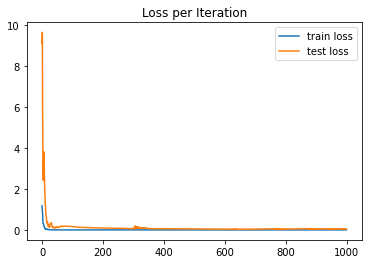

In [62]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.title("Loss per Iteration")


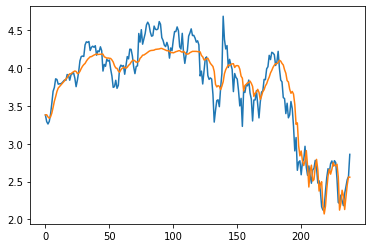

In [63]:
plt.plot(test_targets.cpu())
plt.plot(model(test_inputs).cpu().detach())


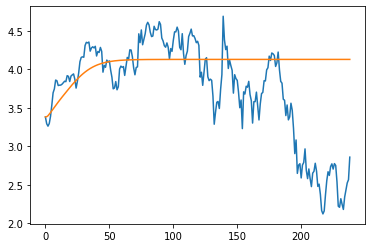

In [64]:
def plot_horizon(): 
    horizon_predictions = []
    horizon_inputs = test_inputs[0]

    while len(horizon_predictions) < len(test_targets):
        prediction = model(horizon_inputs.view(1, T, -1))
        
        horizon_predictions.append(prediction.item())
        horizon_inputs = torch.concat((horizon_inputs[1:], prediction))
    
    plt.plot(test_targets.cpu())  
    plt.plot(horizon_predictions)

plot_horizon() if X.shape == Y.shape else print('Unable to plot Horizon')